<a href="https://colab.research.google.com/github/alex-smith-uwec/CS491/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
my_path="/content/drive/MyDrive/CS491/Data/US_Inaugural_Addresses"

In [ ]:
# Assuming all your text files are in the 'inauguration_speeches' directory
directory = my_path
all_files = os.listdir(directory)


In [ ]:
combined_text = "" # This will store all text combined from all files

for filename in all_files:
    filepath = os.path.join(directory, filename)
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()
        combined_text += text + " " # Ensure there's space between texts

# Use NLTK's sent_tokenize to split the combined text into sentences

In [ ]:
sentences = sent_tokenize(combined_text)


In [ ]:
tokenized_sentences = []
for sentence in sentences:
    # Tokenize each sentence into words and apply lowercasing
    words = word_tokenize(sentence.lower())
    # Remove stopwords
    words_filtered = [word for word in words if word not in stop_words and word.isalpha()]  # isalpha() helps remove punctuation
    tokenized_sentences.append(words_filtered)


In [ ]:
tokenized_sentences[50:52]

[['considerations',
  'lead',
  'adherence',
  'permanent',
  'court',
  'international',
  'justice'],
 ['great',
  'principles',
  'involved',
  'great',
  'movements',
  'way',
  'promise',
  'much',
  'welfare',
  'humanity',
  'reason',
  'fact',
  'many',
  'nations',
  'given',
  'movements',
  'actual',
  'support',
  'ought',
  'withhold',
  'sanction',
  'small',
  'inessential',
  'difference',
  'upon',
  'ground',
  'important',
  'compelling',
  'fundamental',
  'reasons']]

In [ ]:
##How many CPU cores are availabe in Colab?
!cat /proc/cpuinfo | grep processor | wc -l

2


In [ ]:
model = Word2Vec(tokenized_sentences, vector_size=200, window=5, min_count=10, workers=4, epochs=20)
#Set min count up to about 10 to reduce number of words, which makes plotting work.

In [ ]:
len(model.wv.index_to_key)

1400

In [ ]:
# After training, you can use the model to find similar words, etc.
model.wv.most_similar('women',topn=10)

[('men', 0.9656737446784973),
 ('love', 0.9623857140541077),
 ('children', 0.9602592587471008),
 ('faith', 0.9500528573989868),
 ('man', 0.9449720978736877),
 ('lives', 0.9445874094963074),
 ('good', 0.9429126977920532),
 ('greatest', 0.9402933120727539),
 ('live', 0.9394935369491577),
 ('hearts', 0.9379210472106934)]

In [ ]:
# Example words
word1 = "liberty"
word2 = "justice"
word3=  "peace"

# Get the vector for each word
vector1 = model.wv[word1]
vector2 = model.wv[word2]
vector3=model.wv[word3]

# Add the vectors
linear_comb = vector1-vector2+2*vector3

# You can now use the resulting vector to find similar words, for example
# similar_words = model.wv.similar_by_vector(linear_comb,topn=2)

similar_words = model.wv.similar_by_vector(linear_comb,topn=4)
print(similar_words)

[('peace', 0.9650783538818359), ('world', 0.8604377508163452), ('freedom', 0.8415443301200867), ('prosperity', 0.8260446786880493)]


# Plotting word embedding

In [ ]:
# Extract a slice of word vectors, useful if we need to reduce for plotting
words = list(model.wv.index_to_key[0:])  # Adjust the slice for the number of words you want
word_vectors = [model.wv[word] for word in words]

len(word_vectors)

1400

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Convert word vectors into a 2D array of shape (number_of_words, dimensions_of_vectors)
word_vectors_matrix = np.array(word_vectors)

# Initialize and fit PCA
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors_matrix)


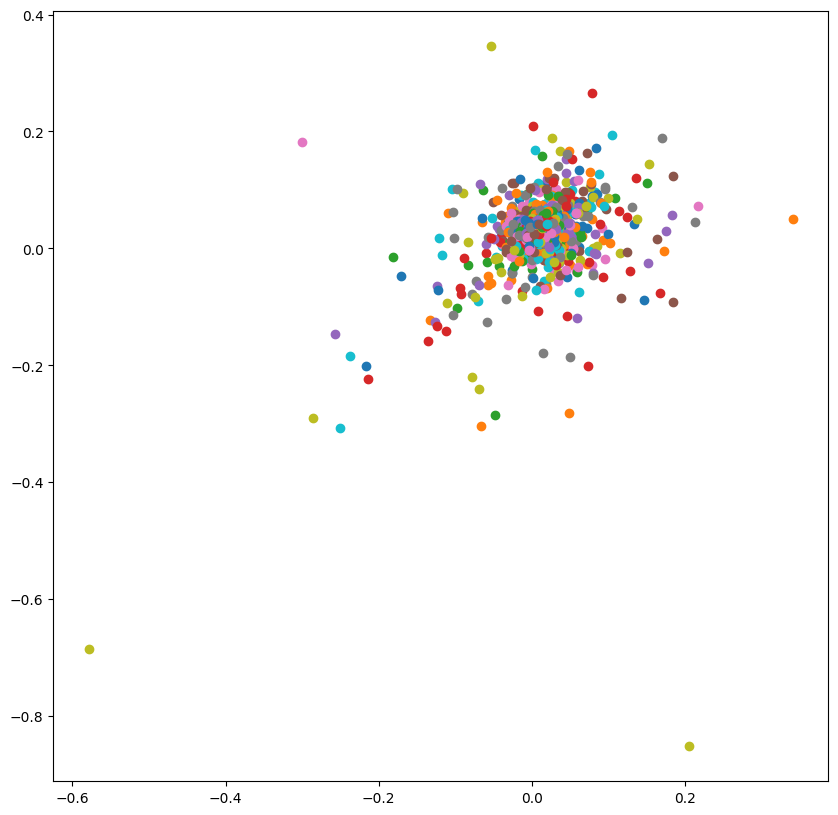

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))

# Iterate over both words and vectors
for vec, word in zip(word_vectors, words):
    plt.scatter(vec[0], vec[1])
    # Optionally, uncomment the next line to display the text labels
    # plt.text(vec[0]+0.00, vec[1]+0.00, word, fontsize=9)

# Set the limits to zoom in
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)

plt.show()
